# Feature Engineering and Modelling

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

In [33]:
# Load dataset
data = pd.read_csv('../data/raw/clean_data_after_eda.csv', parse_dates=['date_activ', 'date_end', 'date_modif_prod', 'date_renewal'])

# Drop unnecessary columns
data.drop(columns=['id'], inplace=True)

# Extract year and month from dates
data['year_activ'] = data['date_activ'].dt.year
data['month_activ'] = data['date_activ'].dt.month
data['year_end'] = data['date_end'].dt.year
data['month_end'] = data['date_end'].dt.month
data['tenure_days'] = (data['date_end'] - data['date_activ']).dt.days

# Compute off-peak price difference (December - January of preceding year)
data['price_diff_dec_jan'] = data['var_6m_price_off_peak'].shift(1) - data['var_6m_price_off_peak'].shift(12)

# Fill missing values
data.fillna(0, inplace=True)

# Encode categorical variables
data = pd.get_dummies(data, columns=['channel_sales'], drop_first=True)

In [34]:
# Define features and target variable
X = data.drop(columns=['churn'])
y = data['churn']

# Normalize numerical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

X_processed = preprocessor.fit_transform(X)


# Split data into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Accuracy: 0.9079

Confusion Matrix:
 [[2637    1]
 [ 268   16]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95      2638
           1       0.94      0.06      0.11       284

    accuracy                           0.91      2922
   macro avg       0.92      0.53      0.53      2922
weighted avg       0.91      0.91      0.87      2922



C:\Users\USER\AppData\Local\Temp\ipykernel_3244\3507838687.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15), palette='viridis')


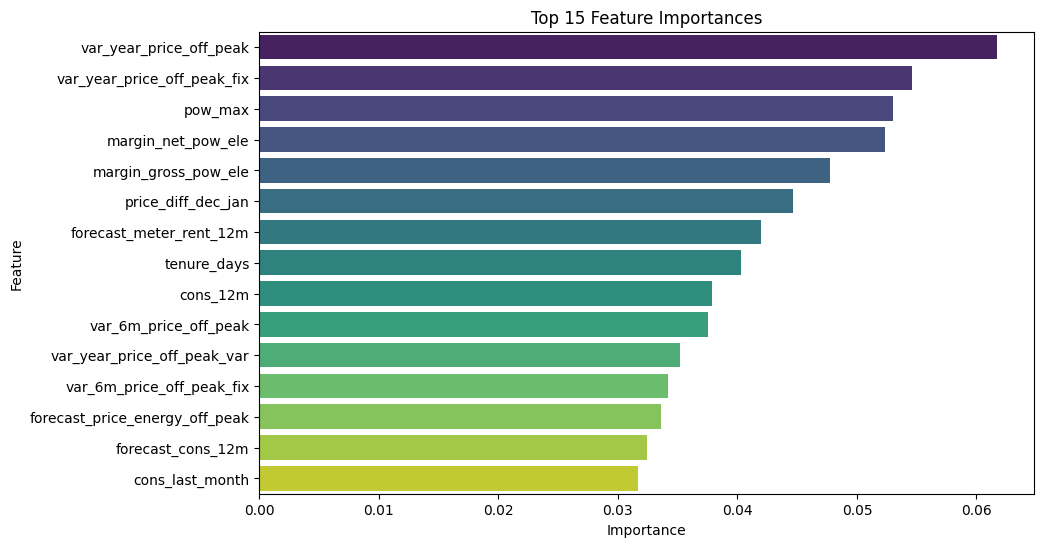

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Best Model Accuracy: 0.8980
ROC-AUC Score: 0.6842
Precision: 0.4167
Recall: 0.1232
F1-Score: 0.1902

Confusion Matrix:
 [[2589   49]
 [ 249   35]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.95      2638
           1       0.42      0.12      0.19       284

    accuracy                           0.90      2922
   macro avg       0.66      0.55      0.57      2922
weighted avg       0.86      0.90      0.87      2922



In [46]:
# Get new column names
num_col_names = numeric_features.tolist()
cat_col_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()

# Store feature names before applying SMOTETomek
feature_names = num_col_names + cat_col_names

# Handle class imbalance with SMOTETomek (alternative to SMOTE)
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

# Convert resampled array back to DataFrame
X_train_resampled = pd.DataFrame(X_train_resampled, columns=feature_names)

# Train RandomForest on resampled data
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Feature Importance Analysis (Fixed)
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15), palette='viridis')
plt.title('Top 15 Feature Importances')
plt.show()

# Hyperparameter Tuning with StratifiedKFold
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    RandomForestClassifier(class_weight={0: 1, 1: 5}, random_state=42),
    param_grid, cv=stratified_kfold, scoring='roc_auc', n_jobs=-1
)

grid_search.fit(X_train_resampled, y_train_resampled)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)

# Train best model
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

# Evaluate best model
best_accuracy = accuracy_score(y_test, y_pred_best)
roc_auc = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])
precision = precision_score(y_test, y_pred_best)
recall = recall_score(y_test, y_pred_best)
f1 = f1_score(y_test, y_pred_best)

print(f"Best Model Accuracy: {best_accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion Matrix and Classification Report
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))